In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# DEG Analysis Script (Updated version with matplotlib style fix)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

# =================== Configuration ===================
expr_file = '/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_TOIL_RSEM_TPM_Levels.csv'
meta_file = '/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_MIR100HG_Expression_Levels.csv'
output_table_dir = '/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED'
output_figure_dir = '/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Figure'
log2fc_threshold = 1.0
padj_threshold = 0.05
use_nonparametric = True
data_is_log2 = True
pseudo_count = 0.001

# create directory
os.makedirs(output_table_dir, exist_ok=True)
os.makedirs(output_figure_dir, exist_ok=True)

# =================== Style Settings ===================
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# =================== Load Data ===================
print("Loading data...")
expr_df = pd.read_csv(expr_file)
gene_info = expr_df[['Ensembl_ID', 'HGNC_Symbol']].copy()
expr_values = expr_df.iloc[:, 2:].copy()
expr_values = expr_values.set_index(expr_df['Ensembl_ID'])

meta_df = pd.read_csv(meta_file)
sample_groups = meta_df[['Patient_ID', 'Group']].dropna()
sample_groups['Group'] = sample_groups['Group'].str.strip()
sample_groups = sample_groups.set_index('Patient_ID')

common_samples = expr_values.columns.intersection(sample_groups.index)
expr_values = expr_values[common_samples]
sample_groups = sample_groups.loc[common_samples]
high_samples = sample_groups[sample_groups['Group'] == 'High'].index
low_samples = sample_groups[sample_groups['Group'] == 'Low'].index

print(f"Total genes: {len(expr_values)}, samples: {len(common_samples)}")

# =================== DEG Analysis ===================
print("Performing DEG analysis...")
results = []

for gene in expr_values.index:
    high_vals = expr_values.loc[gene, high_samples].dropna().values
    low_vals = expr_values.loc[gene, low_samples].dropna().values

    if len(high_vals) < 3 or len(low_vals) < 3:
        continue

    high_mean = np.mean(high_vals)
    low_mean = np.mean(low_vals)
    log2fc = high_mean - low_mean if data_is_log2 else np.log2((high_mean + pseudo_count) / (low_mean + pseudo_count))

    if use_nonparametric:
        try:
            stat, pval = stats.mannwhitneyu(high_vals, low_vals, alternative='two-sided')
        except ValueError:
            pval = 1.0
    else:
        stat, pval = stats.ttest_ind(high_vals, low_vals, equal_var=False)

    gene_symbol = gene_info.loc[gene_info['Ensembl_ID'] == gene, 'HGNC_Symbol'].values[0] if gene in gene_info['Ensembl_ID'].values else gene
    results.append({
        'Ensembl_ID': gene,
        'HGNC_Symbol': gene_symbol,
        'Mean_High': high_mean,
        'Mean_Low': low_mean,
        'Log2_Fold_Change': log2fc,
        'P_Value': pval
    })

deg_df = pd.DataFrame(results)
deg_df['Adj_P_Value'] = multipletests(deg_df['P_Value'], method='fdr_bh')[1]
deg_df['Significant'] = (deg_df['Adj_P_Value'] < padj_threshold) & (abs(deg_df['Log2_Fold_Change']) > log2fc_threshold)
deg_df['Regulation'] = deg_df.apply(lambda x: 'Up' if x['Significant'] and x['Log2_Fold_Change'] > 0 else ('Down' if x['Significant'] and x['Log2_Fold_Change'] < 0 else 'Not Significant'), axis=1)

# =================== Save Results ===================
all_results_path = os.path.join(output_table_dir, 'LUAD_DEG_All_Results.csv')
sig_results_path = os.path.join(output_table_dir, 'LUAD_DEG_Significant_Results.csv')
deg_df.to_csv(all_results_path, index=False)
deg_df[deg_df['Significant']].to_csv(sig_results_path, index=False)
print(f"Save all results to: {all_results_path}")
print(f"Save significant results to: {sig_results_path}")


# =================== Volcano Plot ===================
print("Plotting volcano plot...")
plt.figure(figsize=(10, 8))
plt.scatter(deg_df['Log2_Fold_Change'], -np.log10(deg_df['P_Value']), c='gray', alpha=0.5)
plt.scatter(deg_df[deg_df['Regulation'] == 'Up']['Log2_Fold_Change'], -np.log10(deg_df[deg_df['Regulation'] == 'Up']['P_Value']), c='red', label='Up')
plt.scatter(deg_df[deg_df['Regulation'] == 'Down']['Log2_Fold_Change'], -np.log10(deg_df[deg_df['Regulation'] == 'Down']['P_Value']), c='blue', label='Down')
plt.axhline(-np.log10(padj_threshold), color='black', linestyle='--')
plt.axvline(log2fc_threshold, color='black', linestyle='--')
plt.axvline(-log2fc_threshold, color='black', linestyle='--')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')
plt.title('Volcano Plot: PRAD MIR100HG High vs Low')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_figure_dir, 'LUAD_DEG_Volcano.png'), dpi=300)
plt.close()

print("PRAD DEG analysis completed. Results and plots saved.")

Loading data...
Total genes: 40060, samples: 513
Performing DEG analysis...
保存全部结果到: /Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_DEG_All_Results.csv
保存显著结果到: /Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_DEG_Significant_Results.csv
Plotting volcano plot...
PRAD DEG analysis completed. Results and plots saved.


读取甲基化数据...
甲基化数据形状: (370864, 492)
读取表达数据...
表达数据形状: (513, 4)
读取探针映射数据...
探针映射数据形状: (395985, 6)
探针映射文件的列名: ['Probe_ID', 'HGNC_Symbol', 'chrom', 'chromStart', 'chromEnd', 'strand']
根据MIR100HG表达分组...
高表达组: 257个样本
低表达组: 256个样本
共有样本 - 高表达组: 226个
共有样本 - 低表达组: 230个
执行差异甲基化分析...
执行多重检验校正...
显著差异的甲基化位点: 222
将探针映射到基因...


/var/folders/pp/whvcj4pd64q_srl77pgzt4l00000gn/T/ipykernel_30811/4003550250.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_dmps['Gene'] = sig_dmps['Probe_ID'].map(lambda x: probe_to_gene.get(x, 'Unknown'))


成功映射到基因的探针数量: 152
全部结果已保存为: /Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_DMA_All_Results.csv
显著差异结果已保存为: /Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_DMA_Significant_Results.csv
生成热图可视化...


/Applications/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Applications/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


热图已保存为: /Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Figure/DMA_Heatmap.png
生成热图可视化...


/Applications/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Applications/anaconda3/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


热图已保存为: /Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Figure/LUAD_DMA_Heatmap.png
富集分析图已保存为: /Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Figure/LUAD_DMA_Enrichment.png


<Figure size 1200x1000 with 0 Axes>

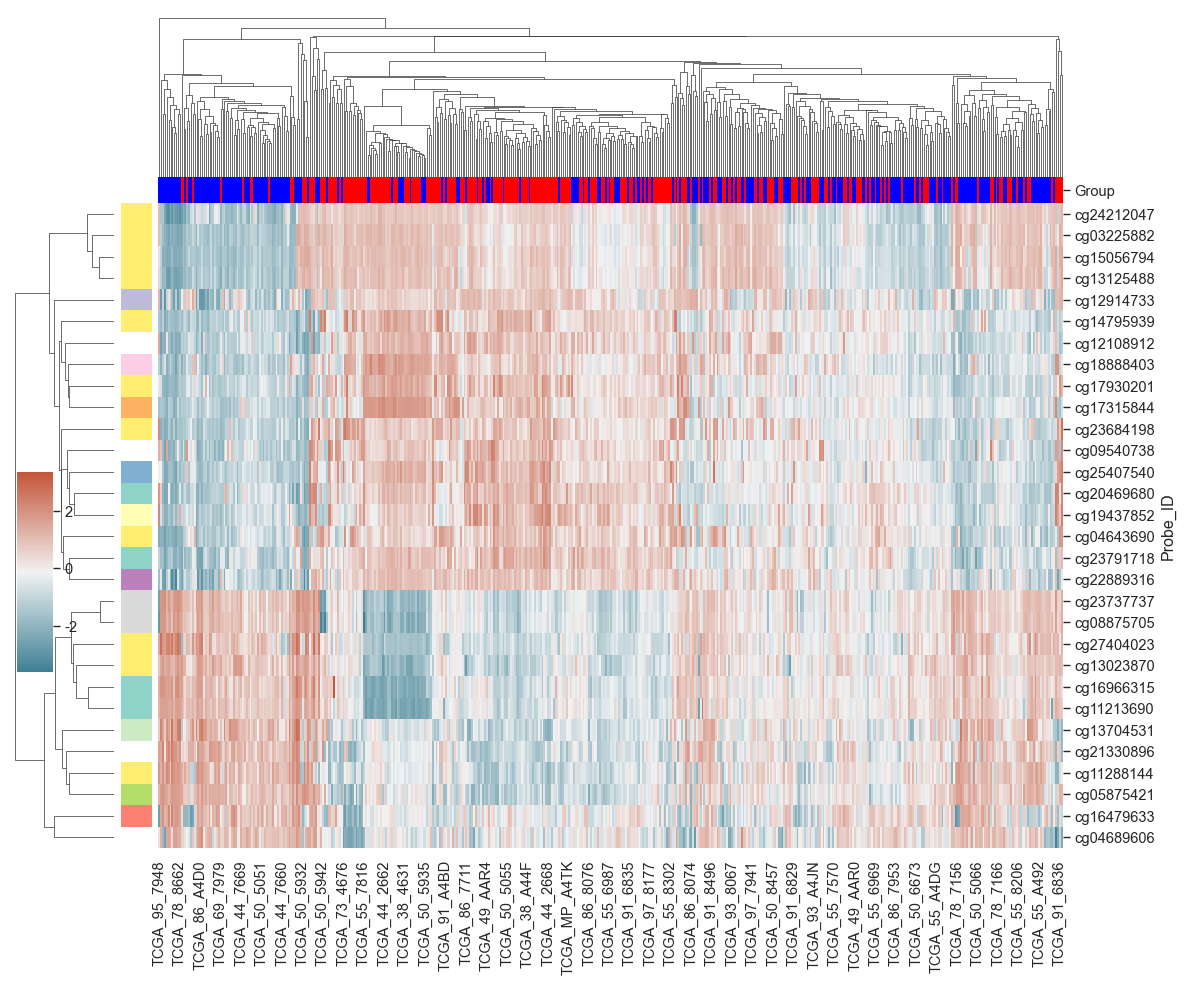

<Figure size 1200x1000 with 0 Axes>

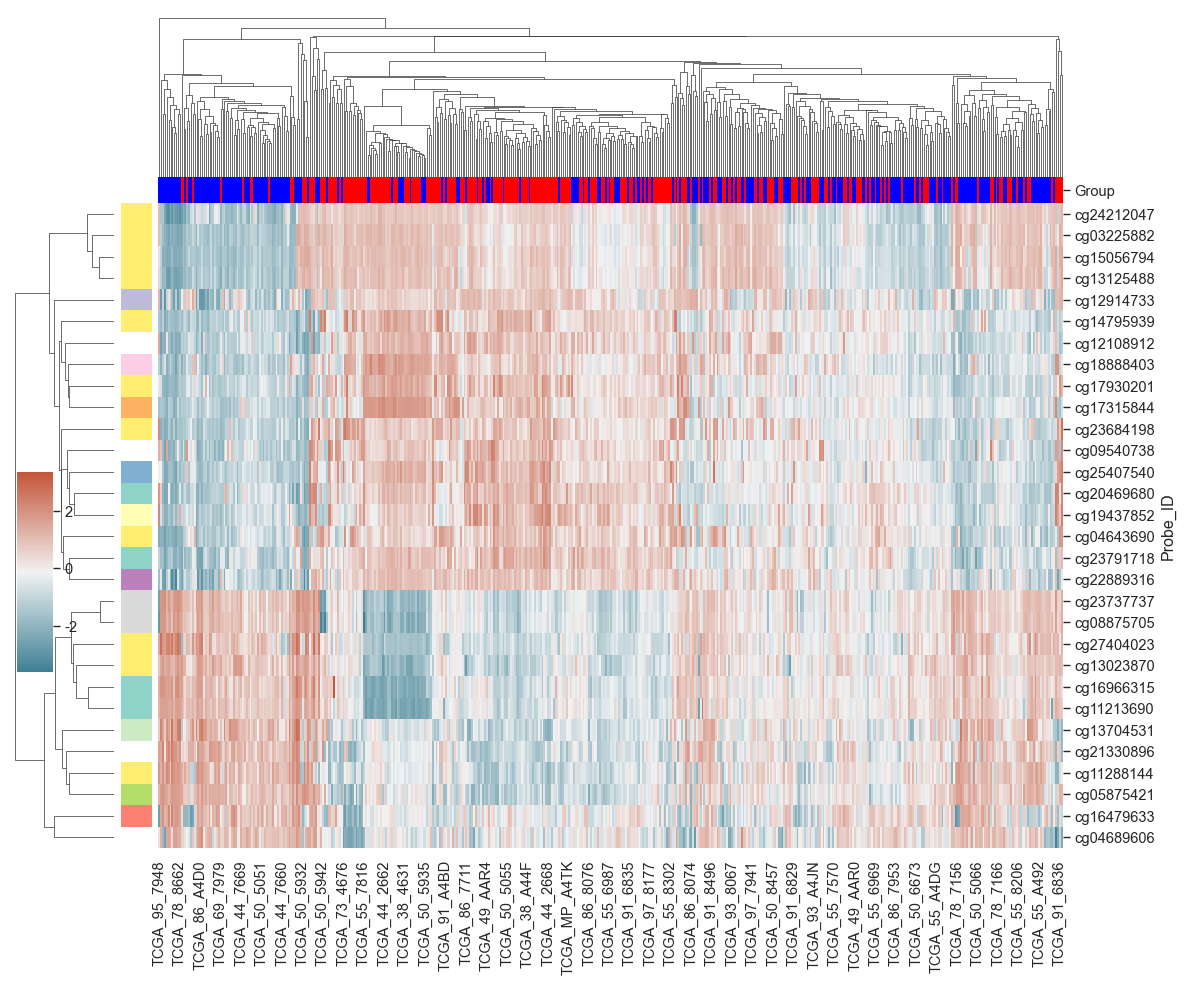

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import os

# Set file path
methylation_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_Methylation_Levels.csv"
expression_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_MIR100HG_Expression_Levels.csv"
probe_map_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA/probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy.csv"

# read data
print("Read methylation data...")
meth_data = pd.read_csv(methylation_file, index_col=0)
print(f"Methylation data shape: {meth_data.shape}")

print("Read expression data...")
expr_data = pd.read_csv(expression_file)
print(f"expression data shape: {expr_data.shape}")

# Read the probe mapping file
print("Read probe mapping data...")
# The first two columns of the file are #id and gene, corresponding to Probe_ID and HGNC_Symbol
probe_map = pd.read_csv(probe_map_file, sep='\t', comment=None)
# If the first column name is #id, rename it to Probe_ID
if probe_map.columns[0] == '#id':
    probe_map = probe_map.rename(columns={'#id': 'Probe_ID', 'gene': 'HGNC_Symbol'})
print(f"Probe mapping data shape: {probe_map.shape}")
print(f"Column name of the probe mapping file: {probe_map.columns.tolist()}")

# data preprocessing

# Convert the sample ID format to match the two data sets
def convert_sample_id(sample_id):
    if isinstance(sample_id, str) and sample_id.startswith('TCGA-'):
        parts = sample_id.split('-')
        if len(parts) >= 3:
            return f"TCGA_{parts[1]}_{parts[2]}"
    return sample_id

# Column name applied to methylation data
meth_cols = meth_data.columns.tolist()
meth_cols_converted = [convert_sample_id(col) for col in meth_cols]
meth_data.columns = meth_cols_converted

# They were grouped according to the expression level of MIR100HG
high_group = expr_data[expr_data['Group'] == 'High']['Patient_ID'].tolist()
low_group = expr_data[expr_data['Group'] == 'Low']['Patient_ID'].tolist()

print(f"high: {len(high_group)}")
print(f"low: {len(low_group)}")

# Screening common samples
high_samples = [s for s in high_group if s in meth_data.columns]
low_samples = [s for s in low_group if s in meth_data.columns]

print(f"Common sample - High: {len(high_samples)}个")
print(f"Common sample - Low: {len(low_samples)}个")

# 6. Differential methylation analysis was performed
results = []
for probe in meth_data.index:
    # extract methylation 
    high_values = meth_data.loc[probe, high_samples].values
    low_values = meth_data.loc[probe, low_samples].values
    
    # drop NaN vakue
    high_values = high_values[~np.isnan(high_values)]
    low_values = low_values[~np.isnan(low_values)]
    
    # The t test is performed only if both groups have sufficient non-nan values
    if len(high_values) >= 3 and len(low_values) >= 3:
        # Calculated mean variance
        mean_diff = np.mean(high_values) - np.mean(low_values)
        
        # t-test
        t_stat, p_value = stats.ttest_ind(high_values, low_values, equal_var=False)
        
        results.append({
            'Probe_ID': probe,
            'Mean_Diff': mean_diff,
            'p_value': p_value
        })

# convert to DataFrame
result_df = pd.DataFrame(results)

# Multiple check correction
print("执行多重检验校正...")
result_df['adj_p_value'] = multipletests(result_df['p_value'], method='fdr_bh')[1]

# Set the significance threshold
padj_threshold = 0.1
abs_mean_diff_threshold = 0.1

# Screen for methylation sites with significant differences
sig_dmps = result_df[(result_df['adj_p_value'] < padj_threshold) & 
                     (abs(result_df['Mean_Diff']) > abs_mean_diff_threshold)]

print(f"Significant differences in methylation sites: {len(sig_dmps)}")


# Create a mapping of probe ID to gene name
# Use the correct column names Probe_ID and HGNC_Symbol
probe_to_gene = dict(zip(probe_map['Probe_ID'], probe_map['HGNC_Symbol']))

# Add gene annotation
sig_dmps['Gene'] = sig_dmps['Probe_ID'].map(lambda x: probe_to_gene.get(x, 'Unknown'))
print(f"Number of probes successfully mapped to genes: {sig_dmps['Gene'].value_counts().shape[0] - (1 if 'Unknown' in sig_dmps['Gene'].values else 0)}")

# Create an output directory and save the results
output_table_dir = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED"
os.makedirs(output_table_dir, exist_ok=True)

# Save all result files
all_results_file = os.path.join(output_table_dir, "LUAD_DMA_All_Results.csv")
result_df.to_csv(all_results_file, index=False)

# Save a significant difference result file
sig_results_file = os.path.join(output_table_dir, "LUAD_DMA_Significant_Results.csv")
sig_dmps.sort_values('adj_p_value').to_csv(sig_results_file, index=False)

print(f"All results have been saved as: {all_results_file}")
print(f"Significant difference results have been saved as: {sig_results_file}")
# Generate heat map visualization


output_fig_dir = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Figure"
os.makedirs(output_fig_dir, exist_ok=True)

# The top 30 significant methylation sites were selected
top_probes = sig_dmps.sort_values('adj_p_value').head(30)['Probe_ID'].tolist()

if top_probes:
    heatmap_data = meth_data.loc[top_probes, high_samples + low_samples]
    sample_groups = pd.Series(['High'] * len(high_samples) + ['Low'] * len(low_samples),
                             index=high_samples + low_samples)
    
    plt.figure(figsize=(12, 10))
    row_annotations = pd.DataFrame({
        'Gene': [probe_to_gene.get(probe, 'Unknown') for probe in top_probes]
    }, index=top_probes)
    
    col_annotations = pd.DataFrame({
        'Group': sample_groups
    })
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    g = sns.clustermap(heatmap_data, 
                      cmap=cmap,
                      z_score=0,
                      row_colors=row_annotations['Gene'].astype('category').cat.codes.map({i: plt.cm.Set3(i) for i in range(20)}),
                      col_colors=col_annotations['Group'].map({'High': 'red', 'Low': 'blue'}),
                      figsize=(12, 10),
                      dendrogram_ratio=(.1, .2),
                      cbar_pos=(.02, .32, .03, .2))
    
    heatmap_file = os.path.join(output_fig_dir, "DMA_Heatmap.png")
    plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
    print(f"The heat map is saved as: {heatmap_file}")
else:
    print("There were not enough significant differences in methylation sites for heat maps")

# Generate heat map visualization
output_fig_dir = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Figure"
os.makedirs(output_fig_dir, exist_ok=True)

# The top 30 significant methylation sites were selected
top_probes = sig_dmps.sort_values('adj_p_value').head(30)['Probe_ID'].tolist()

if top_probes:
    heatmap_data = meth_data.loc[top_probes, high_samples + low_samples]
    sample_groups = pd.Series(['High'] * len(high_samples) + ['Low'] * len(low_samples),
                             index=high_samples + low_samples)
    
    plt.figure(figsize=(12, 10))
    row_annotations = pd.DataFrame({
        'Gene': [probe_to_gene.get(probe, 'Unknown') for probe in top_probes]
    }, index=top_probes)
    
    col_annotations = pd.DataFrame({
        'Group': sample_groups
    })
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    g = sns.clustermap(heatmap_data, 
                      cmap=cmap,
                      z_score=0,
                      row_colors=row_annotations['Gene'].astype('category').cat.codes.map({i: plt.cm.Set3(i) for i in range(20)}),
                      col_colors=col_annotations['Group'].map({'High': 'red', 'Low': 'blue'}),
                      figsize=(12, 10),
                      dendrogram_ratio=(.1, .2),
                      cbar_pos=(.02, .32, .03, .2))
    
    heatmap_file = os.path.join(output_fig_dir, "LUAD_DMA_Heatmap.png")
    plt.savefig(heatmap_file, dpi=300, bbox_inches='tight')
    print(f"The heat map is saved as: {heatmap_file}")
else:
    print("There were not enough significant differences in methylation sites for heat maps")
# Enrichment analysis output picture path
...
enrichment_plot_file = os.path.join(output_fig_dir, "LUAD_DMA_Enrichment.png")
plt.savefig(enrichment_plot_file, dpi=300, bbox_inches='tight')
print(f"The enrichment analysis diagram has been saved a: {enrichment_plot_file}")


In [8]:
!pip install mygene

In [ ]:
import pandas as pd
import mygene
import os
import re


input_path = '/Users/yangqingdi/Desktop/M-28/NTU_DATA/geneAnnotation_hg19_basicgenes.csv'
output_dir = '/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/'
output_path = os.path.join(output_dir, 'Promoter_Region.csv')

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# === Step 1: Read and clean columns ===
df = pd.read_csv(input_path, sep='\t', dtype=str)

# rename column
df = df.rename(columns={
    'chr': 'Promoter_Chr',
    'start': 'Promoter_Start',
    'end': 'Promoter_End',
    'width': 'Promoter_Width',
    'id': 'Promoter_ID',
    'gene_id': 'UCSC_Entrez_ID'  
})

# Delete unwanted columns
df = df.drop(columns=['strand', 'tx_id', 'symbol', 'type'], errors='ignore')

# drop NaN
df = df[df['UCSC_Entrez_ID'].notnull() & (df['UCSC_Entrez_ID'].str.strip() != '')]

# === Step 2: Determine which are UCSC ids and which are Entrez ids ===
def is_ucsc(x):
    return bool(re.match(r'^uc\d+[a-z]+\d*$', x.strip().split('.')[0]))

df['ID_Type'] = df['UCSC_Entrez_ID'].apply(lambda x: 'ucsc' if is_ucsc(x) else 'entrezgene')
df['query_id'] = df['UCSC_Entrez_ID'].str.replace(r'\.\d+$', '', regex=True)  

# === Step 3: Batch query using mygene ===
mg = mygene.MyGeneInfo()

# Check UCSC and Entrez ids separately
results = []

for scope in ['ucsc', 'entrezgene']:
    ids_to_query = df[df['ID_Type'] == scope]['query_id'].unique().tolist()
    print(f"{len(ids_to_query)} 个 {scope} ID...")
    res = mg.querymany(ids_to_query, scopes=scope, fields='symbol', species='human')
    results.extend(res)

# convert to DataFrame
query_df = pd.DataFrame(results)

# Only records of successful mapping are retained
query_df = query_df[query_df['symbol'].notnull() & query_df['query'].notnull()]
query_df = query_df[['query', 'symbol']].drop_duplicates()
query_df.columns = ['query_id', 'HGNC_Symbol']

# === Step 4: Merge back to the primary table ===
df = df.merge(query_df, on='query_id', how='left')
df = df.drop(columns=['ID_Type', 'query_id'])

# === Step 5: save ===
df.to_csv(output_path, index=False)
print(f"{output_path}")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🔍 正在查询 0 个 ucsc ID...


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


🔍 正在查询 23459 个 entrezgene ID...


135 input query terms found no hit:	['100133331', '100616489', '654348', '643314', '23285', '100130000', '728932', '728936', '200058', '


✅ 处理完成！文件已保存至：/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Promoter_Region.csv


# clean gene_attribute_edges.txt

In [ ]:
import pandas as pd

# Original file path
input_path = "/Users/yangqingdi/Desktop/M-28/NTU_DATA/gene_attribute_edges.txt"

# New file saving path
output_path = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/TF_Target.csv"

# Read the original file
df = pd.read_csv(input_path, sep="\t")

# Rename the required columns
df = df.rename(columns={
    "source": "HGNC_Symbol",   
    "source_id": "Gene_ID",    
    "target": "TF_Symbol",            
    "target_id": "TF_ID"       
})

# Delete unwanted columns
df = df.drop(columns=["source_desc", "target_desc", "weight"], errors="ignore")

# Save as a new file
df.to_csv(output_path, index=False)

print(output_path)


/var/folders/pp/whvcj4pd64q_srl77pgzt4l00000gn/T/ipykernel_30811/2571788250.py:10: DtypeWarning: Columns (2,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_path, sep="\t")


✅ 文件已保存为: /Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/TF_Target.csv


In [ ]:
import pandas as pd
import os

# Set file path
input_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA/probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy.csv"
output_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Probe_Map.csv"

# Read the original comment file (tab-separated)
df = pd.read_csv(input_file, sep='\t')

# Rename the column name
df = df.rename(columns={
    '#id': 'Probe_ID',
    'gene': 'HGNC_Symbol',
    'chrom': 'Probe_Chr',
    'chromStart': 'Probe_Chrom_Start',
    'chromEnd': 'Probe_Chrom_End'
})


if 'strand' in df.columns:
    df = df.drop(columns=['strand'])

# Split lines containing multiple hGNC_symbols (separated by commas)
df['HGNC_Symbol'] = df['HGNC_Symbol'].fillna('')
df_expanded = df.assign(HGNC_Symbol=df['HGNC_Symbol'].str.split(',')).explode('HGNC_Symbol')

# Remove the empty string
df_expanded = df_expanded[df_expanded['HGNC_Symbol'].str.strip() != '']

# Reset index and save
df_expanded.reset_index(drop=True, inplace=True)
df_expanded.to_csv(output_file, index=False)

print(f"{output_file}")


探针注释表已成功处理并保存为：/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Probe_Map.csv


In [ ]:
import pandas as pd
import os

# ======= set paths ========
dma_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_DMA_Significant_Results.csv"
probe_map_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Probe_Map.csv"
promoter_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Promoter_Region.csv"
deg_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_DEG_Significant_Results.csv"
output_dir = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED"

os.makedirs(output_dir, exist_ok=True)

# ======= read data ========
dma_df = pd.read_csv(dma_file)
probe_df = pd.read_csv(probe_map_file)
promoter_df = pd.read_csv(promoter_file)
deg_df = pd.read_csv(deg_file)

# ======= Merge DMA and Probe coordinates ========
dma_annotated = dma_df.merge(probe_df, on="Probe_ID", how="left")

# ======= Determine whether the Probe lands in the promoter region ========
matched = []

for _, row in dma_annotated.iterrows():
    hits = promoter_df[
        (promoter_df['Promoter_Chr'] == row['Probe_Chr']) &
        (promoter_df['Promoter_Start'] <= row['Probe_Chrom_Start']) &
        (promoter_df['Promoter_End'] >= row['Probe_Chrom_End'])
    ]
    for _, hit in hits.iterrows():
        matched.append({
            "Probe_ID": row["Probe_ID"],
            "HGNC_Symbol": hit["HGNC_Symbol"],
            "Mean_Diff": row["Mean_Diff"],
            "adj_p_value": row["adj_p_value"]
        })

# convert to DataFrame
promoter_hits_df = pd.DataFrame(matched)

# ======= Save all intra-promoter probes ========
promoter_hits_path = os.path.join(output_dir, "Methylation_Probes_in_Promoters.csv")
promoter_hits_df.to_csv(promoter_hits_path, index=False)
print(f"{promoter_hits_path}")

# ======= Joint DEG to express data ========
deg_filtered = deg_df[["HGNC_Symbol", "Log2_Fold_Change"]]
merged = promoter_hits_df.merge(deg_filtered, on="HGNC_Symbol", how="left")

# ======= promoter methylation ========
up_meth_down_expr = merged[
    (merged["Mean_Diff"] > 0.15) & 
    (merged["Log2_Fold_Change"] < -0.5)
].dropna()

up_meth_down_path = os.path.join(output_dir, "Promoters_Methylation_Up_Expression_Down.csv")
up_meth_down_expr.to_csv(up_meth_down_path, index=False)
print(f"promoter methylation↑ + expression↓ gene：{up_meth_down_path}")


down_meth_up_expr = merged[
    (merged["Mean_Diff"] < -0.15) & 
    (merged["Log2_Fold_Change"] > 0.5)
].dropna()

down_meth_up_path = os.path.join(output_dir, "Promoters_Methylation_Down_Expression_Up.csv")
down_meth_up_expr.to_csv(down_meth_up_path, index=False)
print(f"promoter methylation↓ + expression↑ gene：{down_meth_up_path}")


✅ 所有启动子区域的 probe 保存至：/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Methylation_Probes_in_Promoters.csv
✅ 启动子甲基化↑ + 表达↓ 的基因保存至：/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Promoters_Methylation_Up_Expression_Down.csv
✅ 启动子甲基化↓ + 表达↑ 的基因保存至：/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Promoters_Methylation_Down_Expression_Up.csv


In [ ]:
import pandas as pd
import gzip
import requests
import os

# ========== Step 1: Download the GTF file (Ensembl GRCh38） ==========
gtf_url = "http://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens/Homo_sapiens.GRCh38.109.gtf.gz"
gtf_path = "Homo_sapiens.GRCh38.109.gtf.gz"

if not os.path.exists(gtf_path):
    r = requests.get(gtf_url, stream=True)
    with open(gtf_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print("done")

# ========== Step 2: gene region extraction ==========
genes = []
with gzip.open(gtf_path, 'rt') as f:
    for line in f:
        if line.startswith("#"):
            continue
        parts = line.strip().split("\t")
        if parts[2] != "gene":
            continue
        chr_, source, type_, start, end, score, strand, phase, attributes = parts
        attr_dict = {k.strip(): v.strip('"') for k, v in [field.strip().split(" ") for field in attributes.strip(";").split(";") if field]}
        if 'gene_name' in attr_dict:
            # The standardized chromosome format is chrN
            chr_fixed = chr_ if chr_.startswith("chr") else f"chr{chr_}"
            gene = {
                "HGNC_Symbol": attr_dict['gene_name'],
                "Gene_Chr": chr_fixed,
                "Gene_Start": int(start),
                "Gene_End": int(end)
            }
            genes.append(gene)

# ========== Step 3: Save as Gene_Region.csv in the specified location ==========
output_path = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Gene_Region.csv"
gene_df = pd.DataFrame(genes)
gene_df = gene_df[gene_df["Gene_Chr"].str.startswith("chr")]  
gene_df.to_csv(output_path, index=False)
print(f"Genome annotation file has been saved to：{output_path}")


🔽 正在下载 GTF 文件...
✅ 下载完成！
📁 基因体注释文件已保存至：/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Gene_Region.csv


In [ ]:
import pandas as pd

# ======= set path =======
dma_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_DMA_Significant_Results.csv"
probe_map_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Probe_Map.csv"
promoter_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Promoter_Region.csv"
deg_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/LUAD_DEG_Significant_Results.csv"
gene_region_file = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED/Gene_Region.csv"
output_dir = "/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED"

# ======= read data =======
dma_df = pd.read_csv(dma_file)
probe_df = pd.read_csv(probe_map_file)
promoter_df = pd.read_csv(promoter_file)
deg_df = pd.read_csv(deg_file)
gene_region_df = pd.read_csv(gene_region_file)

# Merge probe coordinate information
dma_annotated = dma_df.merge(probe_df, on="Probe_ID", how="left")

# Screen probe in promoter region
promoter_probes = set()
for _, row in promoter_df.iterrows():
    hits = dma_annotated[
        (dma_annotated['Probe_Chr'] == row['Promoter_Chr']) &
        (dma_annotated['Probe_Chrom_Start'] >= row['Promoter_Start']) &
        (dma_annotated['Probe_Chrom_End'] <= row['Promoter_End'])
    ]
    promoter_probes.update(hits['Probe_ID'].tolist())

non_promoter_df = dma_annotated[~dma_annotated['Probe_ID'].isin(promoter_probes)]

# Matching genomic regions
matched = []
for _, row in non_promoter_df.iterrows():
    hits = gene_region_df[
        (gene_region_df['Gene_Chr'] == row['Probe_Chr']) &
        (gene_region_df['Gene_Start'] <= row['Probe_Chrom_Start']) &
        (gene_region_df['Gene_End'] >= row['Probe_Chrom_End'])
    ]
    for _, hit in hits.iterrows():
        matched.append({
            "Probe_ID": row["Probe_ID"],
            "HGNC_Symbol": hit["HGNC_Symbol"],
            "Mean_Diff": row["Mean_Diff"],
            "adj_p_value": row["adj_p_value"]
        })

gene_body_hits_df = pd.DataFrame(matched)

# Joint DEG to express data
deg_filtered = deg_df[["HGNC_Symbol", "Log2_Fold_Change"]]
merged = gene_body_hits_df.merge(deg_filtered, on="HGNC_Symbol", how="left")

# Promoter exomethylation decreased and promoter expression increased
hypo_up = merged[
    (merged["Mean_Diff"] < -0.15) & 
    (merged["Log2_Fold_Change"] > 0.5)
].dropna()

# Promoter exomethylation is up-regulated
hyper_down = merged[
    (merged["Mean_Diff"] > 0.15) & 
    (merged["Log2_Fold_Change"] < -0.5)
].dropna()

# save
hypo_up.to_csv(f"{output_dir}/GeneBody_Methylation_Down_Expression_Up.csv", index=False)
hyper_down.to_csv(f"{output_dir}/GeneBody_Methylation_Up_Expression_Down.csv", index=False)
gene_body_hits_df.to_csv(f"{output_dir}/Methylation_Probes_in_GeneBody.csv", index=False)


print(" - Promoter exomethylation decreased and promoter expression increased → GeneBody_Methylation_Down_Expression_Up.csv")
print(" - Promoter exomethylation is up-regulated → GeneBody_Methylation_Up_Expression_Down.csv")
print(" - probe of all genomic regions hit → Methylation_Probes_in_GeneBody.csv")


✅ 分析完成，结果已保存：
 - 启动子外甲基化下降 + 表达上升 → GeneBody_Methylation_Down_Expression_Up.csv
 - 启动子外甲基化上升 + 表达下调 → GeneBody_Methylation_Up_Expression_Down.csv
 - 所有命中基因体区域的 probe → Methylation_Probes_in_GeneBody.csv


In [ ]:


import pandas as pd
import numpy as np
import os

# Directory containing the CSV files
base_dir = '/Users/yangqingdi/Desktop/M-28/NTU_DATA_CLEANED'

# List of CSV files to process
files = [
    'GeneBody_Methylation_Down_Expression_Up.csv',
    'GeneBody_Methylation_Up_Expression_Down.csv',
    'Methylation_Probes_in_GeneBody.csv',
    'Methylation_Probes_in_Promoters.csv',
    'Promoters_Methylation_Down_Expression_Up.csv',
    'Promoters_Methylation_Up_Expression_Down.csv'
]

results = {}

# Function to load and analyze CSV files
def analyze_csv(file_path):
    df = pd.read_csv(file_path)
    analysis = {
        'row_count': len(df),
        'column_names': df.columns.tolist(),
        'sample_data': df.head(3).to_dict(orient='records')
    }

    # Detailed analysis for specific files
    if 'Methylation_Probes_in_GeneBody.csv' in file_path:
        mean_diff = df['Mean_Diff'].dropna()
        analysis['mean_diff_stats'] = {
            'min': mean_diff.min(),
            'max': mean_diff.max(),
            'avg': mean_diff.mean()
        }

    if 'Methylation_Probes_in_Promoters.csv' in file_path:
        mean_diff = df['Mean_Diff'].dropna()
        positive = (mean_diff > 0).sum()
        negative = (mean_diff < 0).sum()
        analysis['mean_diff_stats'] = {
            'min': mean_diff.min(),
            'max': mean_diff.max(),
            'avg': mean_diff.mean(),
            'positive_count': positive,
            'negative_count': negative,
            'positive_percentage': f"{positive / len(mean_diff) * 100:.2f}%",
            'negative_percentage': f"{negative / len(mean_diff) * 100:.2f}%"
        }

    if 'Promoters_Methylation_Down_Expression_Up.csv' in file_path:
        log2fc = df['Log2_Fold_Change'].dropna()
        mean_diff = df['Mean_Diff'].dropna()
        analysis['expression_stats'] = {
            'min_log2fc': log2fc.min(),
            'max_log2fc': log2fc.max(),
            'avg_log2fc': log2fc.mean(),
            'avg_mean_diff': mean_diff.mean()
        }

    return analysis

# Process each file
for file in files:
    file_path = os.path.join(base_dir, file)
    try:
        results[file] = analyze_csv(file_path)
    except Exception as e:
        results[file] = {'error': str(e)}

# Generate summary statistics
summary = {
    'total_promoter_probes': results.get('Methylation_Probes_in_Promoters.csv', {}).get('row_count', 0),
    'total_gene_body_probes': results.get('Methylation_Probes_in_GeneBody.csv', {}).get('row_count', 0),
    'promoter_methyl_down_expr_up': results.get('Promoters_Methylation_Down_Expression_Up.csv', {}).get('row_count', 0),
    'promoter_methyl_up_expr_down': results.get('Promoters_Methylation_Up_Expression_Down.csv', {}).get('row_count', 0),
    'gene_body_methyl_down_expr_up': results.get('GeneBody_Methylation_Down_Expression_Up.csv', {}).get('row_count', 0),
    'gene_body_methyl_up_expr_down': results.get('GeneBody_Methylation_Up_Expression_Down.csv', {}).get('row_count', 0)
}

# Display results
print("Summary of Analysis:", summary)

if 'Promoters_Methylation_Down_Expression_Up.csv' in results:
    print("Detailed Expression Stats (Promoters Down Methylation & Expression Up):", 
          results['Promoters_Methylation_Down_Expression_Up.csv'].get('expression_stats', {}))

if 'GeneBody_Methylation_Down_Expression_Up.csv' in results:
    print("Gene Body Row Count:", results['GeneBody_Methylation_Down_Expression_Up.csv']['row_count'])
    print("Gene Body Sample Data:", results['GeneBody_Methylation_Down_Expression_Up.csv']['sample_data'])

if 'Methylation_Probes_in_Promoters.csv' in results:
    print("Promoter Region Methylation Distribution:", 
          results['Methylation_Probes_in_Promoters.csv'].get('mean_diff_stats', {}))

print("Count of Promoter Methylation Up & Expression Down Genes:", 
      summary['promoter_methyl_up_expr_down'])

Summary of Analysis: {'total_promoter_probes': 791, 'total_gene_body_probes': 35, 'promoter_methyl_down_expr_up': 0, 'promoter_methyl_up_expr_down': 0, 'gene_body_methyl_down_expr_up': 0, 'gene_body_methyl_up_expr_down': 0}
Detailed Expression Stats (Promoters Down Methylation & Expression Up): {'min_log2fc': nan, 'max_log2fc': nan, 'avg_log2fc': nan, 'avg_mean_diff': nan}
Gene Body Row Count: 0
Gene Body Sample Data: []
Promoter Region Methylation Distribution: {'min': -0.1313881265701328, 'max': 0.1579706701103708, 'avg': 0.05175552577785268, 'positive_count': 577, 'negative_count': 214, 'positive_percentage': '72.95%', 'negative_percentage': '27.05%'}
Count of Promoter Methylation Up & Expression Down Genes: 0
